In [1]:
import torch
from dataset import Planetoid
import os.path as osp
import torch_geometric.transforms as T
import numpy as np

from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
from aug import augment_GRACE, augment_CCA
from torch_geometric.utils import add_self_loops
from utils.utils import *
import random

2025-01-03 14:57:24.046479: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-03 14:57:24.085631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-03 14:57:24.085667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-03 14:57:24.086809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 14:57:24.093374: I tensorflow/core/platform/cpu_feature_guar

In [22]:
name = 'CiteSeer'
path = osp.join('datasets', name)
split = 'imbalance'
imb_ratio = 10
fix_minority = True
model_name = 'GRACE'
dataset = Planetoid(path, name, split=split, imb_ratio= imb_ratio, fix_minority= fix_minority, transform = T.NormalizeFeatures())
data = dataset[0]

Using Existing Training Masks


In [23]:
config_citeseer = {
  'use_seed': False,
  'add_self_loops': False,
  'seed': 38108,
  'learning_rate': 0.001,
  'hid_dim': 256,
  'proj_hidden_dim': 256,
  'activation': 'prelu',
  'base_model': 'GCNConv',
  'num_layers': 2,
  'drop_edge_rate_1': 0.2,
  'drop_edge_rate_2': 0.0,
  'drop_feature_rate_1': 0.3,
  'drop_feature_rate_2': 0.2,
  'tau': 0.9,
  'num_epochs': 200,
  'weight_decay': 0.00001,
  'BalanceMLP':{
    'epochs': 2000,
    'lr': 0.01,
    'weight_decay': 0.000005,
    'dropout': 0.5,
    'num_proj_layers': 1,
    'proj_hid_dim': 64}
}
torch.manual_seed(config_citeseer['seed'])
random.seed(12345)
from SSL.GRACE import Encoder, Model
encoder = Encoder(dataset.num_features, config_citeseer['hid_dim'], activation=({'relu': F.relu, 'prelu': nn.PReLU()})[config_citeseer['activation']],
                base_model=({'GCNConv': GCNConv})[config_citeseer['base_model']], k=config_citeseer['num_layers']).cuda()
model = Model(encoder, config_citeseer['proj_hidden_dim'], config_citeseer['proj_hidden_dim'], config_citeseer['tau']).cuda()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config_citeseer['learning_rate'], weight_decay=config_citeseer['weight_decay'])

data = data.cuda()

In [24]:
for epoch in range(1, config_citeseer['num_epochs'] + 1):
    model.train()
    optimizer.zero_grad()
    x = data.x
    edge_index = data.edge_index
    edge_index_1, edge_index_2, x_1, x_2 = augment_GRACE(config_citeseer, x, edge_index)
    if config_citeseer['add_self_loops']:
        edge_index_1 = add_self_loops(edge_index_1)[0]
        edge_index_2 = add_self_loops(edge_index_2)[0]
    z1 = model(x_1, edge_index_1)
    z2 = model(x_2, edge_index_2)
    loss = model.loss(z1, z2, batch_size=0)
    loss.backward()
    optimizer.step()
    print(f'(T) | Epoch={epoch:03d}, loss={loss:.4f}')

(T) | Epoch=001, loss=8.8028
(T) | Epoch=002, loss=8.8027
(T) | Epoch=003, loss=8.8026
(T) | Epoch=004, loss=8.8021
(T) | Epoch=005, loss=8.8007
(T) | Epoch=006, loss=8.7959
(T) | Epoch=007, loss=8.7835
(T) | Epoch=008, loss=8.7504
(T) | Epoch=009, loss=8.6763
(T) | Epoch=010, loss=8.5257
(T) | Epoch=011, loss=8.4098
(T) | Epoch=012, loss=8.4099
(T) | Epoch=013, loss=8.4355
(T) | Epoch=014, loss=8.3661
(T) | Epoch=015, loss=8.3257
(T) | Epoch=016, loss=8.2486
(T) | Epoch=017, loss=8.2190
(T) | Epoch=018, loss=8.2119
(T) | Epoch=019, loss=8.1713
(T) | Epoch=020, loss=8.1692
(T) | Epoch=021, loss=8.1735
(T) | Epoch=022, loss=8.1326
(T) | Epoch=023, loss=8.1177
(T) | Epoch=024, loss=8.1106
(T) | Epoch=025, loss=8.0944
(T) | Epoch=026, loss=8.0897
(T) | Epoch=027, loss=8.0687
(T) | Epoch=028, loss=8.0510
(T) | Epoch=029, loss=8.0420
(T) | Epoch=030, loss=8.0373
(T) | Epoch=031, loss=8.0108
(T) | Epoch=032, loss=7.9978
(T) | Epoch=033, loss=7.9979
(T) | Epoch=034, loss=7.9756
(T) | Epoch=03

## Store Embeddings

In [27]:
# test
model.eval()
z = model(x, edge_index)
z = z.detach().cpu()
save_embeddings(z, path=osp.join('embeddings', name + '_' + model_name+'.pt')) 

Saved.


## Load GRACE Embedding on Citeseer dataset

In [28]:
z = load_embeddings(osp.join('embeddings', name + '_' + model_name+'.pt'))

## Stage 2: Classifier

In [31]:
from balance import balance_embedding_mean_cls, balance_embedding_assign, BalanceMLP
from sklearn.metrics import f1_score, balanced_accuracy_score
from eval import label_classification

n_cls   = dataset.num_classes
balanced_mlp = BalanceMLP(config_citeseer, z.shape[1], n_cls).cuda()
optimizer_mlp = torch.optim.Adam(balanced_mlp.parameters(), 
                                 lr=config_citeseer['BalanceMLP']['lr'], 
                                 weight_decay=config_citeseer['BalanceMLP']['weight_decay'])
loss_func_mlp = nn.CrossEntropyLoss()

imb_train_masks = data.imb_train_masks
imb_train_mask = imb_train_masks[7]  # The worst mask
data.imb_train_mask = imb_train_mask

balanced_data = balance_embedding_assign(dataset, data, z, n_cls, metric='inner_product')
data = balanced_data



train_mask = data.imb_train_mask
new_y = data.new_y
# new_y = data.y

y     = data.y
best_val_f1 = 0
best_test_acc, best_test_f1,best_test_bacc= 0, 0, 0
best_val_epoch = -1

## Fix Embeddings and Learn the Decision Boundary

In [32]:
for e in range(config_citeseer['BalanceMLP']['epochs']):
    balanced_mlp.train()
    optimizer_mlp.zero_grad()
    x = z.cuda()
    new_y = new_y.cuda()
    train_mask = train_mask.cuda()
    logits = balanced_mlp(x)
    loss_mlp = loss_func_mlp(logits[train_mask], new_y[train_mask])  # 利用伪训练集标签训练分类器
    loss_mlp.backward()
    optimizer_mlp.step()
    with torch.no_grad():
        balanced_mlp.eval()
        val_mask  = data.val_mask.cuda()
        y         = data.y.cuda()
        test_mask = data.test_mask.cuda()
        preds = balanced_mlp(x).argmax(dim = -1)

        y_val = y[val_mask].detach().cpu().numpy()
        y_test = y[test_mask].detach().cpu().numpy()
        val_preds = preds[val_mask].detach().cpu().numpy()
        test_preds  = preds[test_mask].detach().cpu().numpy()

        acc_val = f1_score(y_val, val_preds, average='micro')
        f1_val      = f1_score(y_val, val_preds, average='macro')
        bacc_val    = balanced_accuracy_score(y_val, val_preds)
        acc_test    = f1_score(y_test, test_preds, average='micro')
        f1_test     = f1_score(y_test, test_preds, average='macro')
        bacc_test    = balanced_accuracy_score(y_test, test_preds)
        if f1_val >= best_val_f1:
            best_val_epoch = e
            best_val_f1 = f1_val
            best_test_acc = acc_test
            best_test_f1  = f1_test
            best_test_bacc = bacc_test
    print("<Epoch %d> [Val Acc] %.4f [Val F1] %.4f [Val bacc] %.4f <Best Val:> [Epoch] %d <Test:> [Test Acc] %.4f [Test F1] %.4f [Test bacc] %.4f" % (
        epoch, acc_val,f1_val,bacc_val, best_val_epoch, best_test_acc, best_test_f1, best_test_bacc
    ))
print("[Test Acc] %.4f [Test F1] %.4f [Test bacc] %.4f" % (best_test_acc, best_test_f1, best_test_bacc)) 

<Epoch 200> [Val Acc] 0.1880 [Val F1] 0.1167 [Val bacc] 0.2557 <Best Val:> [Epoch] 0 <Test:> [Test Acc] 0.1590 [Test F1] 0.1019 [Test bacc] 0.2367
<Epoch 200> [Val Acc] 0.1960 [Val F1] 0.1295 [Val bacc] 0.2625 <Best Val:> [Epoch] 1 <Test:> [Test Acc] 0.1780 [Test F1] 0.1233 [Test bacc] 0.2553
<Epoch 200> [Val Acc] 0.2980 [Val F1] 0.2936 [Val bacc] 0.3814 <Best Val:> [Epoch] 2 <Test:> [Test Acc] 0.3010 [Test F1] 0.2985 [Test bacc] 0.3672
<Epoch 200> [Val Acc] 0.3380 [Val F1] 0.3423 [Val bacc] 0.3970 <Best Val:> [Epoch] 3 <Test:> [Test Acc] 0.3710 [Test F1] 0.3640 [Test bacc] 0.4131
<Epoch 200> [Val Acc] 0.3660 [Val F1] 0.3642 [Val bacc] 0.4112 <Best Val:> [Epoch] 4 <Test:> [Test Acc] 0.4010 [Test F1] 0.3864 [Test bacc] 0.4311
<Epoch 200> [Val Acc] 0.3900 [Val F1] 0.3794 [Val bacc] 0.4236 <Best Val:> [Epoch] 5 <Test:> [Test Acc] 0.4110 [Test F1] 0.3923 [Test bacc] 0.4280
<Epoch 200> [Val Acc] 0.3980 [Val F1] 0.3824 [Val bacc] 0.4298 <Best Val:> [Epoch] 6 <Test:> [Test Acc] 0.4310 [Test F

## Draw Embeddings and Minority Class Training nodes

In [44]:
train_labels = data.y[imb_train_mask]
train_idx = imb_train_mask.nonzero().flatten()

minority_nodes = train_idx[(train_labels >= n_cls//2)].detach().cpu().numpy()

minority_nodes

array([ 8, 21, 26, 47, 61, 97])

In [46]:
y[minority_nodes]  # labels of minority class training nodes

tensor([3, 5, 5, 4, 3, 4], device='cuda:0')

In [47]:
from sklearn.manifold import TSNE
import enum
import matplotlib.pyplot as plt
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,

labels = data.y.detach().cpu().numpy()
train_labels = data.y[imb_train_mask]
train_idx = imb_train_mask.nonzero().flatten()

train_labels = train_labels.detach().cpu().numpy()
train_idx    = train_idx.detach().cpu().numpy()

# 6个label
all_labels = np.zeros(data.num_nodes).astype(np.int64) + dataset.num_classes
all_labels[train_idx] = train_labels  # 所有training labels
embs = z.detach().cpu().numpy()

[ 8 21 26 47 61 97]
[3 5 5 4 3 4]


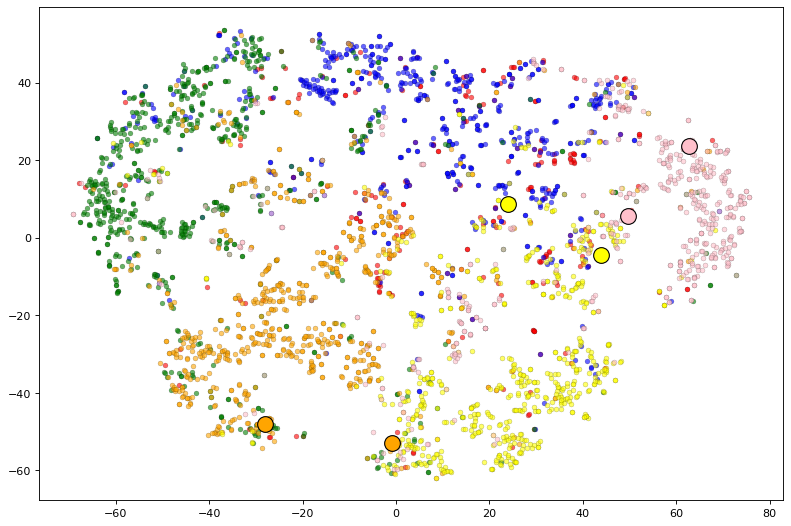

In [48]:
minority_nodes = minority_nodes
minority_labels = labels[minority_nodes]
print(minority_nodes)
print(minority_labels)

t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(embs)
citeseer_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}
fig = plt.figure(figsize=(12,8), dpi=80)
for class_id in range(dataset.num_classes):
    plt.scatter(t_sne_embeddings[labels == class_id, 0], t_sne_embeddings[labels == class_id, 1], s = 20, color=citeseer_label_to_color_map[class_id], edgecolors='black', linewidths=0.2, alpha = 0.6)

for node, label in zip(minority_nodes, minority_labels):
    plt.scatter(t_sne_embeddings[node, 0], t_sne_embeddings[node, 1], s = 200, color=citeseer_label_to_color_map[label], edgecolors='black', linewidths=1, alpha=1)

plt.show()

## Draw representation space decision boundary

In [52]:
from sklearn.linear_model import LogisticRegression

X_cl = t_sne_embeddings[train_idx]
Y_cl = labels[train_idx]
lr_cl_2d = LogisticRegression(multi_class='multinomial', max_iter=2000)
lr_cl_2d.fit(X_cl, Y_cl)

x_min, x_max = t_sne_embeddings[:, 0].min() - 1, t_sne_embeddings[:, 0].max() + 1
y_min, y_max = t_sne_embeddings[:, 1].min() - 1, t_sne_embeddings[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = lr_cl_2d.predict(grid_points)
Z = Z.reshape(xx.shape)

In [51]:
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel2')  # color regions by predicted class

# Plot the actual node positions
all_labels = data.y.cpu().numpy()
plt.scatter(ce_2d[:, 0], ce_2d[:, 1], c=all_labels, cmap='Set1', edgecolors='k')
plt.title("CE Loss Embeddings + Decision Boundary")
plt.show()

array([1, 1, 0, 3, 2, 2, 1, 2, 2, 0, 1, 5, 2, 5, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 1, 4, 2, 2, 2, 1, 1, 2, 2, 3, 1, 2, 1, 1, 0, 2, 0, 2, 1, 1,
       0, 1, 4, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])